In [139]:
from manifold_learning import IMD
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
from tensorflow.keras.datasets import mnist
importlib.reload(IMD)
importlib.reload(utils)

<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [642]:
X = get_truncated_lorenz_rand(2000,100000)[None]
Y = X[:,:,[0]]

X_emb = utils.get_td_embedding_np(X[0,:,[2]].T,30,1).reshape(-1,30*1)

In [103]:
X = np.array([np.sin(np.linspace(0,200/((i+1)*0.1337),20000)) for i in range(5)]).sum(axis=0)[:,None]
X_emb = utils.get_td_embedding_np(X,5,30,return_pred=False)[:,:,0]
#X_emb = X_emb @ np.random.normal(0,1,(30,100))
X_emb = StandardScaler().fit_transform(X_emb)

In [115]:
X = np.array([get_truncated_lorenz_rand(280,n_steps=20000)[:,0] for i in range(5)]).T
#X = X @ np.random.uniform(-1,1,(5,50))
X_emb = utils.get_td_embedding_np(X,5,4,return_pred=False)
X_emb = X_emb.reshape(X_emb.shape[0],-1)
X_emb = StandardScaler().fit_transform(X_emb)

In [127]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_emb = x_train
y_emb = y_train

In [151]:
trainer = IMD.MCM_reg(X_emb.shape[1], embed_dim=2, subtract_corr=False, device="cuda")

In [155]:
trainer.fit(X_emb, y_emb[:,None], sample_len=600, library_len=2200, 
            exclusion_rad=1, nbrs_num=100, 
            epochs=1000, num_batches=32,optimizer="Adam", learning_rate=0.0001)


Epoch 1/1000, Loss: 0.0312
Epoch 2/1000, Loss: 0.0299
Epoch 3/1000, Loss: 0.0299
Epoch 4/1000, Loss: 0.0315
Epoch 5/1000, Loss: 0.0296
Epoch 6/1000, Loss: 0.0285
Epoch 7/1000, Loss: 0.0294
Epoch 8/1000, Loss: 0.0306
Epoch 9/1000, Loss: 0.0298
Epoch 10/1000, Loss: 0.0290
Epoch 11/1000, Loss: 0.0294
Epoch 12/1000, Loss: 0.0299
Epoch 13/1000, Loss: 0.0282
Epoch 14/1000, Loss: 0.0280
Epoch 15/1000, Loss: 0.0283
Epoch 16/1000, Loss: 0.0270
Epoch 17/1000, Loss: 0.0279
Epoch 18/1000, Loss: 0.0270
Epoch 19/1000, Loss: 0.0299
Epoch 20/1000, Loss: 0.0261
Epoch 21/1000, Loss: 0.0267
Epoch 22/1000, Loss: 0.0256
Epoch 23/1000, Loss: 0.0281
Epoch 24/1000, Loss: 0.0253
Epoch 25/1000, Loss: 0.0284
Epoch 26/1000, Loss: 0.0269
Epoch 27/1000, Loss: 0.0273
Epoch 28/1000, Loss: 0.0242
Epoch 29/1000, Loss: 0.0271
Epoch 30/1000, Loss: 0.0264
Epoch 31/1000, Loss: 0.0263
Epoch 32/1000, Loss: 0.0253
Epoch 33/1000, Loss: 0.0246
Epoch 34/1000, Loss: 0.0261
Epoch 35/1000, Loss: 0.0253
Epoch 36/1000, Loss: 0.0237
E

KeyboardInterrupt: 

In [118]:
plt.matshow(trainer.model.get_weights()[:,0,1].reshape(28,28))

AttributeError: 'Sequential' object has no attribute 'weight'

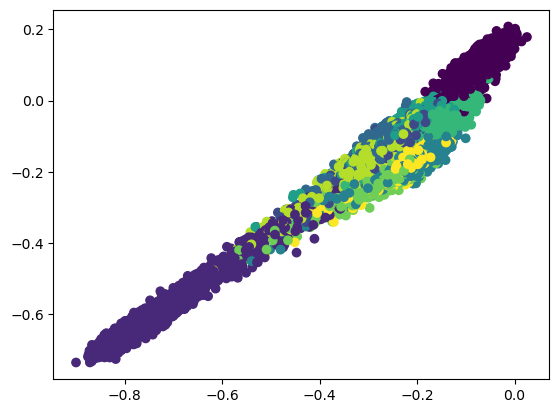

In [156]:
unmixed = trainer.predict(X_emb)

plt.scatter(unmixed[:,0,1],unmixed[:,0,0],c=y_emb)

In [157]:
CCM.PairwiseCCM(device="cpu").compute(y_emb[None,:,None], unmixed[:,0,0][None,:,None], 2000, 600, 30, 30, 0)

array([[[0.98223925]]], dtype=float32)

In [121]:
trainer = IMD.IMD_nD(X_emb.shape[1], embed_dim=10, n_components=5,subtract_corr=False, device="cuda")

In [194]:
trainer.fit(X_emb, sample_len=600, library_len=2200, 
            exclusion_rad=50, nbrs_num=30, tp=20, 
            epochs=1000, num_batches=1,optimizer="Adam", learning_rate=0.01,tp_policy="range")


Epoch 1/1000, Loss: 1.0889
Epoch 2/1000, Loss: 1.0609
Epoch 3/1000, Loss: 1.0221
Epoch 4/1000, Loss: 0.9847
Epoch 5/1000, Loss: 0.9522
Epoch 6/1000, Loss: 0.9226


KeyboardInterrupt: 

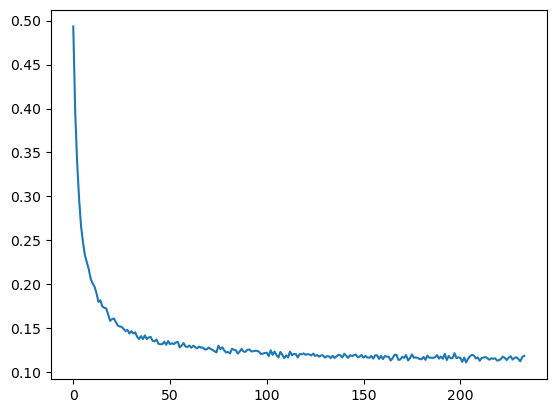

In [67]:
plt.plot(trainer.get_loss_history()[:])


In [50]:

unmixed = trainer.predict(X_emb)

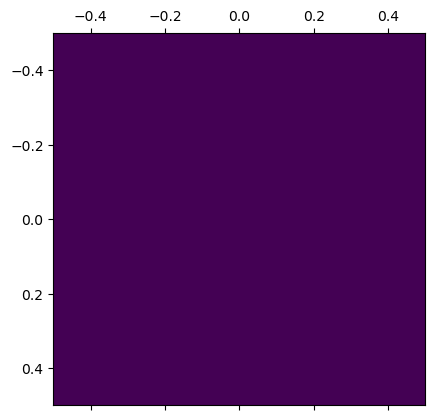

In [44]:
ccm = CCM.PairwiseCCM(device="cpu")
plt.matshow(ccm.compute(np.transpose(unmixed,(1,0,2)), np.transpose(unmixed,(1,0,2)), 2000, 450, 20, 20, 0).mean(axis=0))

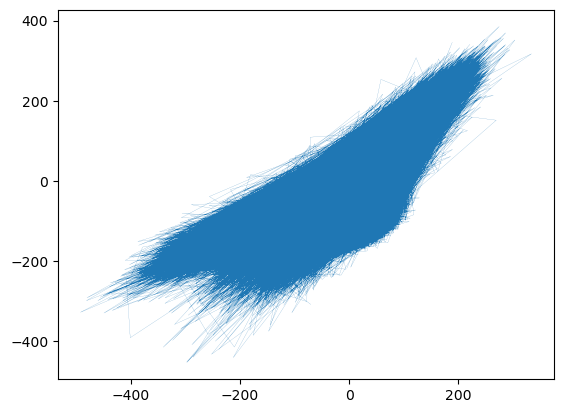

In [51]:
plt.plot(unmixed[:,0,1],unmixed[:,0,0],linewidth=0.1)

In [124]:
ccm = CCM.PairwiseCCM(device="cpu")
ccm.compute(unmixed[:,0][None],Y,20000,5000,30,15,0)

NameError: name 'Y' is not defined

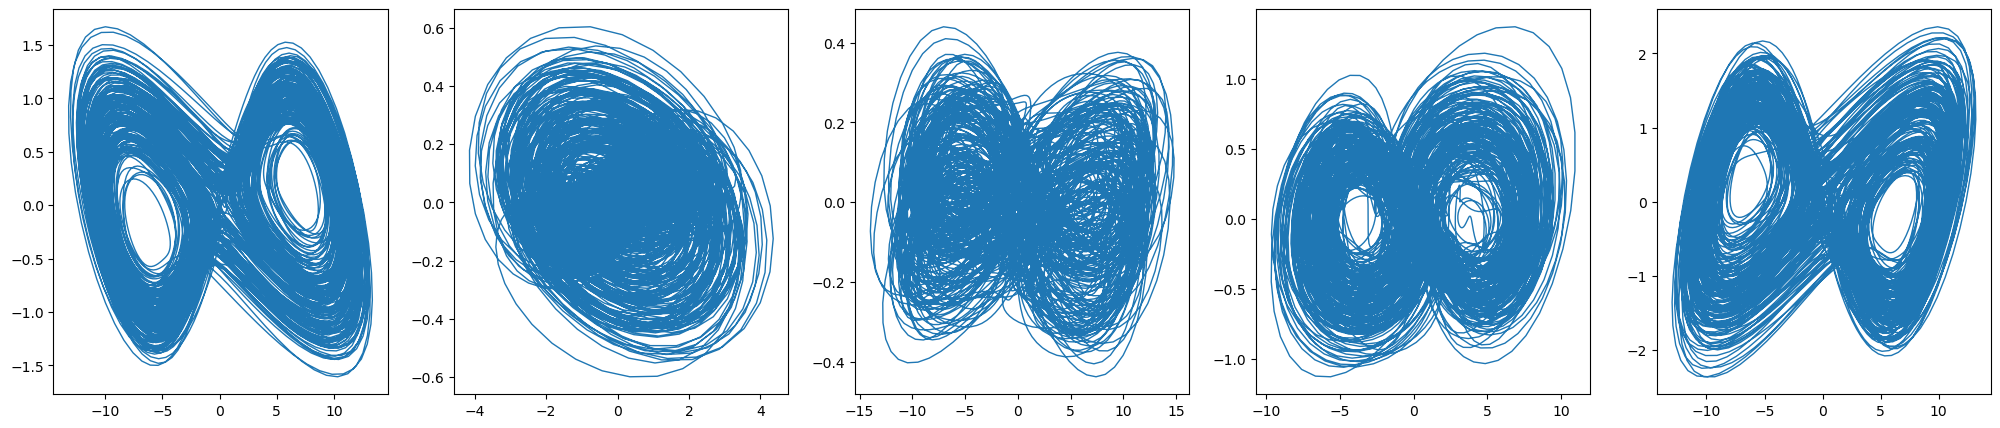

In [191]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

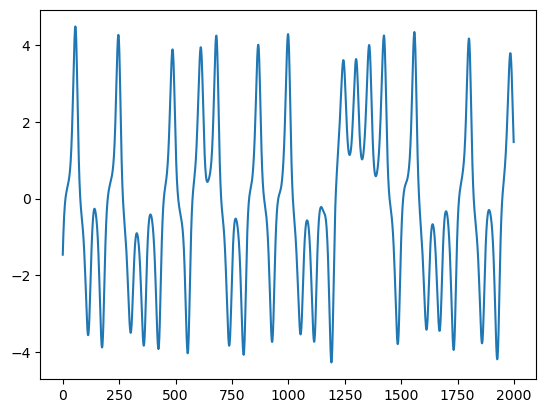

In [192]:
plt.plot(unmixed[:2000,0,0])

In [184]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,3,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()